# Projekt: Titanic, survival prediction

## Inhaltsverzeichnis
- [Einleitung](#1)<br>
- [Benötigte Imports](#2)<br>
- [Laden der Datensätze](#3)<br>
- [Beschreibung des Datensatzes](#4)<br>
- [Data Exploration](#5)<br>
    - [NaN Werte verarbeiten (Embarked und Fare)](#10)
- [Feature Engineering](#6)<br>
    - [Feature: Geschlecht der Passagiere](#7)<br>
    - [Feature: Titel-Mapping](#8)<br>
    - [Feature: Ist Kind](#8)<br>
    - [Feature: Alter auffüllen](#8)<br>
    - [Feature: Altersgruppen](#8)<br>
    - [Feature: Familiengröße (Family_Size)](#8)<br>
    - [Feature: Überlebensrate von Familien](#9)<br>
    - [Feature: Abfuhrhafen Cherbourg (C)](#9)<br>
    - [Feature: Fahrpreis pro Person](#9)<br>
    - [Feature: Fahrpreisgruppen](#9)<br>
- [Data Preprocessing](#11)<br>
- [Modells](#12)<br>
    - [XGBoost](#12)<br>
        - [Modell-Setup](#12)<br>
        - [Modell-Training](#13)<br>
        - [Modell-Prediction](#14)<br>
    - [K-Neares Neighbors](#12)<br>
        - [Modell-Setup](#12)<br>
        - [Modell-Training](#13)<br>
        - [Modell-Prediction](#14)<br>


<a id="1"></a>
## Einleitung

Informationen zum Notebook:

Autor: Ivan Birkmaier<br>
Martrikelnummer: 52305064<br>
Username: ai23m049<br>
____

Modul: Development Project AI<br>
Lektor: Brandmayr Georg

Projektbeschreibung: **Vorhersage der Überlebenschancen beim Titanic-Unglück**

Das Titanic-Unglück von 1912 gehört zu den bekanntesten Katastrophen der Seefahrtsgeschichte. Von den 2224 Passagieren und Besatzungsmitgliedern an Bord kamen 1502 ums Leben, als das Schiff nach der Kollision mit einem Eisberg sank. Dieses tragische Ereignis bietet einen einzigartigen Datensatz für historische und statistische Analysen. <br> 
Das Ziel dieses Projekts ist es, ein Vorhersagemodell zu entwickeln, das die Überlebenschancen der Passagiere basierend auf verfügbaren Passagierdaten einschätzt. Eine besondere Herausforderung dabei ist, dass diebereitgestellten  Daten kein Geschlecht der Passagiere beinhalten, was üblicherweise ein signifikanter Faktor in Überlebensvorhersagemodellen ist.

<a id="2"></a>
## Benötigte Imports

Im folgenden werden alle für dieses Notebook benötigten Bibliotheken eingebunden. Zusätzlich werden Bibliotheken in den gewählten Kernal installiert, sollten diese nicht vorhanden sein.

In [80]:
# Installieren der notwendigen Pakete, falls sie noch nicht installiert sind
%pip install pandas numpy seaborn requests matplotlib scikit-learn xgboost

print("\nVersionen der installierten Bibliotheken")
import pandas as pd
print('pandas:', pd.__version__)
import numpy as np
print('numpy:', np.__version__)
import seaborn as sns
print('seaborn:', sns.__version__)
import re
import requests
print('requests:', requests.__version__)
import matplotlib.pyplot as plt
# print('matplotlib:', plt.__version__)
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
import sklearn
print('scikit-learn:', sklearn.__version__)
from xgboost import XGBClassifier
import xgboost
print('xgboost:', xgboost.__version__)
from pathlib import Path
import os
import warnings
warnings.filterwarnings('ignore')

label_encoder = LabelEncoder()


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.

Versionen der installierten Bibliotheken
pandas: 2.2.1
numpy: 1.26.2
seaborn: 0.13.2
requests: 2.31.0
scikit-learn: 1.4.1.post1



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


<a id="3"></a>
## Laden der Datensätze

In [81]:
data_path = Path.cwd()

# Laden der Trainingsdaten
train_data = pd.read_csv(data_path/'../csv/original_data/train.csv', index_col=0)
train_data = train_data.reset_index() #um Id zu behalten als spalte

# Laden der Testdaten
test_data = pd.read_csv(data_path/'../csv/original_data/test.csv', index_col=0)
test_data = test_data.reset_index() #um Id zu behalten als spalte

# Markiere die Datensätze als 'Train' oder 'Test'
train_data['Dataset'] = 'Train'
test_data['Dataset'] = 'Test'

# Kombiniere beide Datensätze
feature_engineering_df = pd.concat([train_data, test_data], ignore_index=True)

feature_engineering_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Age          1046 non-null   float64
 5   SibSp        1309 non-null   int64  
 6   Parch        1309 non-null   int64  
 7   Ticket       1309 non-null   object 
 8   Fare         1308 non-null   float64
 9   Cabin        295 non-null    object 
 10  Embarked     1307 non-null   object 
 11  Dataset      1309 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


<a id="4"></a>
## Beschreibung des Datensatzes

Die folgende Beschreibung des Datensatzes stammt aus folgender Quelle: [Titanic Dataset auf Kaggle](https://www.kaggle.com/competitions/titanic/data)


| Variable  | Definition                     | Key                                          |
|-----------|--------------------------------|----------------------------------------------|
| survival  | Survival                       | 0 = No, 1 = Yes                              |
| pclass    | Ticket class                   | 1 = 1st, 2 = 2nd, 3 = 3rd                    |
| sex       | Sex                            |                                              |
| Age       | Age in years                   |                                              |
| sibsp     | # of siblings / spouses aboard the Titanic |                                              |
| parch     | # of parents / children aboard the Titanic |                                              |
| ticket    | Ticket number                  |                                              |
| fare      | Passenger fare                 |                                              |
| cabin     | Cabin number                   |                                              |
| embarked  | Port of Embarkation            | C = Cherbourg, Q = Queenstown, S = Southampton |

**Variable Notes:**

- **pclass:** A proxy for socio-economic status (SES)
  - 1st = Upper
  - 2nd = Middle
  - 3rd = Lower
- **age:** Age is fractional if less than 1. If the age is estimated, it is in the form of xx.5.
- **sibsp:** The dataset defines family relations in this way...
  - Sibling = brother, sister, stepbrother, stepsister
  - Spouse = husband, wife (mistresses and fiancés were ignored)
- **parch:** The dataset defines family relations in this way...
  - Parent = mother, father
  - Child = daughter, son, stepdaughter, stepson
  - Some children travelled only with a nanny, therefore parch=0 for them.


<a id="5"></a>
## Date Exploration

Generelle deskriptive Kennzahlen:

In [82]:
feature_engineering_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,1309.000000,891.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,655.000000,0.383838,2.294882,29.881138,0.498854,0.385027,33.295479
std,378.020061,0.486592,0.837836,14.413493,1.041658,0.865560,51.758668
min,1.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,328.000000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,655.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,982.000000,1.000000,3.000000,39.000000,1.000000,0.000000,31.275000
max,1309.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200


Überlebensrate der Trainingsdaten:

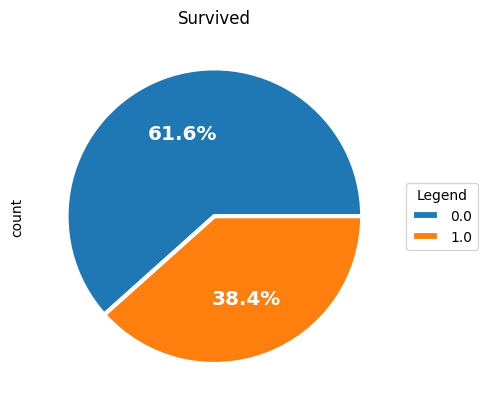

In [83]:
# Filtern der Daten, um nur Einträge zu berücksichtigen, bei denen 'Survived' nicht gleich 2 ist
filtered_df = feature_engineering_df[feature_engineering_df.Survived != 2]

# Erstellen des Kreisdiagramms auf Basis der gefilterten Daten
pie_chart = filtered_df.Survived.value_counts().plot.pie(autopct='%.1f%%', 
                                                         wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'}, 
                                                         textprops=dict(size='x-large', color='white', fontweight='bold'))
pie_chart.set_title('Survived')

# Hinzufügen der Legende unter Verwendung der Indizes der Serie, die nun die gefilterten Labels enthalten
labels = filtered_df.Survived.value_counts().index
plt.legend(labels, title="Legend", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.show()


Überlebensrate verteilt auf die unterschiedlichen Passagierklassen Survival ratio per Pclass: 

In [84]:
feature_engineering_df.groupby(['Pclass']).Survived.agg(Survivor_ratio='mean', Passengers='size')

,Survivor_ratio,Passengers
Pclass,,
1,0.629630,323
2,0.472826,277
3,0.242363,709


In [85]:
feature_engineering_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Age          1046 non-null   float64
 5   SibSp        1309 non-null   int64  
 6   Parch        1309 non-null   int64  
 7   Ticket       1309 non-null   object 
 8   Fare         1308 non-null   float64
 9   Cabin        295 non-null    object 
 10  Embarked     1307 non-null   object 
 11  Dataset      1309 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


<a id="10"></a>
### NaN Werte verarbeiten (Embarked, Fare und Cabin)

Insgesamt fehlen bei Embarked zwei einträge und bei Fare ein Eintrag (siehe oben).
- Embareked: Einfach Southempton (S) genommen weil da am meisten eingestiegen sind: Höhste Wahrscheinlichkeit.
- Fare: Mit dem Durchschnittsticketpreis aufgefüllt.
Da in der Spalte Cabin ca 1000 Einträge fehlen wurde sich dazu entschieden dieses Feature nicht mehr weiter zu betrachten und aus dem Datensatz zu entfernen. (Ich habe echt lang versucht eine sinnvolle Methode zu finden die Cabin-Daten zu verwerten, aber keine Change.)

In [86]:
feature_engineering_df["Embarked"].fillna(value="S", inplace=True)
feature_engineering_df["Fare"].fillna(value=feature_engineering_df["Fare"].mean(), inplace=True)
feature_engineering_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Age          1046 non-null   float64
 5   SibSp        1309 non-null   int64  
 6   Parch        1309 non-null   int64  
 7   Ticket       1309 non-null   object 
 8   Fare         1309 non-null   float64
 9   Cabin        295 non-null    object 
 10  Embarked     1309 non-null   object 
 11  Dataset      1309 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


<a id="6"></a>
## Feature Engineering

<a id="7"></a>
### Feature: Geschlecht der Passagiere

Es wird versucht über den Namen der Pasagieren (mit Titel/Ansprache z.B Mr.) auf das Geschlecht der Passagiere Rückschlüsse zu ziehen. Grund hierfür ist dass aus rechereche sich ergeben hat das Frauen und Kinder vor den Männern gerettet wurden.

In [87]:
# Funktion, um Namen in ihre Bestandteile zu teilen
def split_name(name):
    parts = re.split(r'[,\. ]+', name)
    surname = parts[0]
    speech = parts[1]
    first_name = " ".join(parts[2:])
    return surname, speech, first_name

# Namen in Bestandteile aufteilen und zu DataFrame hinzufügen
feature_engineering_df[['Surname', 'Titel', 'First_Name']] = feature_engineering_df.apply(lambda x: split_name(x['Name']), axis=1, result_type='expand')

feature_engineering_df.head(2)

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Dataset,Surname,Titel,First_Name
0,1,0.0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,S,Train,Braund,Mr,Owen Harris
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,C,Train,Cumings,Mrs,John Bradley (Florence Briggs Thayer)


Überprüfen ob das trennen der Name Spalte vollständig geklappt hat:

In [88]:
feature_engineering_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Age          1046 non-null   float64
 5   SibSp        1309 non-null   int64  
 6   Parch        1309 non-null   int64  
 7   Ticket       1309 non-null   object 
 8   Fare         1309 non-null   float64
 9   Cabin        295 non-null    object 
 10  Embarked     1309 non-null   object 
 11  Dataset      1309 non-null   object 
 12  Surname      1309 non-null   object 
 13  Titel        1309 non-null   object 
 14  First_Name   1309 non-null   object 
dtypes: float64(3), int64(4), object(8)
memory usage: 153.5+ KB


Überprüfung der entstandenen Titel:

In [89]:
unique_speech_values = feature_engineering_df["Titel"].unique()
print(unique_speech_values)

['Mr' 'Mrs' 'Miss' 'Master' 'Planke' 'Don' 'Rev' 'Billiard' 'der' 'Walle'
 'Dr' 'Pelsmaeker' 'Mulder' 'y' 'Steen' 'Carlo' 'Mme' 'Impe' 'Ms' 'Major'
 'Gordon' 'Messemaeker' 'Mlle' 'Col' 'Capt' 'Velde' 'the' 'Shawah'
 'Jonkheer' 'Melkebeke' 'Cruyssen' 'Khalil' 'Palmquist' 'Brito']


**Typische Titel**:
  - **'Mr'**: Ein allgemeiner Titel für einen erwachsenen Mann.
  - **'Mrs'**: Ein Titel für eine verheiratete Frau.
  - **'Miss'**: Ein Titel für eine unverheiratete Frau.
  - **'Master'**: Ein traditioneller Titel für einen jungen Mann oder Jungen, oft verwendet für Kinder.
  - **'Don'**: Ein Titel, der in einigen spanischsprachigen Ländern sowie in Italien verwendet wird, oft vor dem Vornamen.
  - **'Rev'** (Reverend): Ein religiöser Titel, verwendet für Mitglieder des Klerus.
  - **'Dr'**: Ein akademischer oder professioneller Titel für Personen, die einen Doktorgrad in einem Fachgebiet haben.
  - **'Mme'** (Madame): Ein französischer Titel für eine verheiratete Frau.
  - **'Ms'**: Ein neutraler Titel für Frauen, unabhängig vom Familienstand.
  - **'Major'**: Ein militärischer Rang.
  - **'Mlle'** (Mademoiselle): Ein französischer Titel für eine unverheiratete Frau.
  - **'Col'** (Colonel): Ein militärischer Rang.
  - **'Capt'** (Captain): Ein militärischer Rang oder ein Titel für den Kapitän eines Schiffs oder Flugzeugs.
  - **'Jonkheer'**: Ein niederländischer Adelstitel, äquivalent zu einem unbeerbten Adligen oder einem "Junker".

**Weniger typische oder kontextabhängige Titel**:
  - **'Planke'**, **'Billiard'**, **'der'**, **'Walle'**, **'Pelsmaeker'**, **'Mulder'**, **'y'**, **'Steen'**, **'Carlo'**, **'Impe'**, **'Gordon'**, **'Messemaeker'**, **'Velde'**, **'the'**, **'Shawah'**, **'Melkebeke'**, **'Cruyssen'** **'Brito'** 

Analysieren der Daten mit untypischen Titeln:

In [90]:
specific_speech_values = [
    'Planke', 'Billiard', 'der', 'Walle', 'Pelsmaeker', 'Mulder', 'y', 'Steen', 
    'Carlo', 'Impe', 'Gordon', 'Messemaeker', 'Velde', 'the', 'Shawah', 
    'Melkebeke', 'Cruyssen', 'Brito'
]

filtered_df = feature_engineering_df[feature_engineering_df['Titel'].isin(specific_speech_values)]
filtered_df

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Dataset,Surname,Titel,First_Name
18,19,0.0,3,"Vander Planke, Mrs. Julius (Emelia Maria Vande...",31.0,1,0,345763,18.0000,NaN,S,Train,Vander,Planke,Mrs Julius (Emelia Maria Vandemoortele)
38,39,0.0,3,"Vander Planke, Miss. Augusta Maria",18.0,2,0,345764,18.0000,NaN,S,Train,Vander,Planke,Miss Augusta Maria
153,154,0.0,3,"van Billiard, Mr. Austin Blyler",40.5,0,2,A/5. 851,14.5000,NaN,S,Train,van,Billiard,Mr Austin Blyler
170,171,0.0,1,"Van der hoef, Mr. Wyckoff",61.0,0,0,111240,33.5000,B19,S,Train,Van,der,hoef Mr Wyckoff
200,201,0.0,3,"Vande Walle, Mr. Nestor Cyriel",28.0,0,0,345770,9.5000,NaN,S,Train,Vande,Walle,Mr Nestor Cyriel
282,283,0.0,3,"de Pelsmaeker, Mr. Alfons",16.0,0,0,345778,9.5000,NaN,S,Train,de,Pelsmaeker,Mr Alfons
286,287,1.0,3,"de Mulder, Mr. Theodore",30.0,0,0,345774,9.5000,NaN,S,Train,de,Mulder,Mr Theodore
307,308,1.0,1,"Penasco y Castellana, Mrs. Victor de Satode (M...",17.0,1,0,PC 17758,108.9000,C65,C,Train,Penasco,y,Castellana Mrs Victor de Satode (Maria Josefa ...
333,334,0.0,3,"Vander Planke, Mr. Leo Edmondus",16.0,2,0,345764,18.0000,NaN,S,Train,Vander,Planke,Mr Leo Edmondus
355,356,0.0,3,"Vanden Steen, Mr. Leo Peter",28.0,0,0,345783,9.5000,NaN,S,Train,Vanden,Steen,Mr Leo Peter


Man kann erkennen dass Klammern und Anführungszeichen das Problem sind, weshalb der Split nicht richtig geklappt hat. Erneutes durchführen mit verbesserter Methode:

In [91]:
# Entferne die Spalten 'Surname', 'Speech', 'First_Name' aus dem DataFrame
feature_engineering_df = feature_engineering_df.drop(["Surname", 'Titel', "First_Name"], axis=1)


def split_name_advanced(name):
    name_cleaned = re.sub(r'["\(\)].*?["\(\)]', '', name)
    parts = re.split(r'[,\.]+ ?', name_cleaned)
    
    surname = parts[0] if len(parts) > 0 else ""
    speech = parts[1] if len(parts) > 1 else ""
    first_name = " ".join(parts[2:]) if len(parts) > 2 else ""
    first_name = re.sub(' +', ' ', first_name).strip()
    
    return surname, speech, first_name


# Namen in Bestandteile aufteilen und zu DataFrame hinzufügen
feature_engineering_df[['Surname', 'Titel', 'First_Name']] = feature_engineering_df.apply(lambda x: split_name_advanced(x['Name']), axis=1, result_type='expand')

unique_speech_values = feature_engineering_df['Titel'].unique()
print(unique_speech_values)

['Mr' 'Mrs' 'Miss' 'Master' 'Don' 'Rev' 'Dr' 'Mme' 'Ms' 'Major' 'Lady'
 'Sir' 'Mlle' 'Col' 'Capt' 'the Countess' 'Jonkheer' 'Dona']


**Eindeutig geschlechtsspezifische Titel:**
- **'Mr'**: Männlich
- **'Mrs'**: Weiblich, verheiratet
- **'Miss'**: Weiblich, unverheiratet
- **'Master'**: Männlich, typischerweise ein Junge oder sehr junger Mann
- **'Mme'** (Madame): Weiblich, verheiratet
- **'Ms'**: Weiblich, unabhängig vom Familienstand
- **'Mlle'** (Mademoiselle): Weiblich, unverheiratet
- **'Lady'**: Weiblich, verwendet für eine Frau von Adel oder die Ehefrau eines Ritters
- **'Sir'**: Männlich, verwendet für einen Mann, der zum Ritter geschlagen wurde
- **'the Countess'**: Weiblich, die Ehefrau eines Earls oder eine Gräfin in eigenem Recht
- **'Jonkheer'**: Männlich, niederländischer Adelstitel ohne Erbanspruch
- **'Dona'**: Weiblich

**Titel, die potenziell beiden Geschlechtern zugeordnet sein können:**
- **'Don'**: Traditionell männlich, aber in einigen Kulturen auch für Frauen in der Form "Doña" verwendet.
- **'Rev'** (Reverend): Kann sowohl männliche als auch weibliche Geistliche bezeichnen.
- **'Dr'**: Geschlechtsneutral, bezieht sich auf Personen mit einem Doktorgrad in jeglichem Fachbereich.
- **'Major'**, **'Col'** (Colonel), **'Capt'** (Captain): Diese militärischen Ränge sind geschlechtsneutral, da sie sowohl von Männern als auch von Frauen erreicht werden können.

Mit Hilfe der genderize.io API werden die Pasagiere, bei denen das geschlecht nicht über ienen Titel bestimmte werden kann über den Vornamen klassifiziert. 

In [92]:
def guess_gender_api(name):
    try:
        response = requests.get(f"https://api.genderize.io/?name={name}")
        response.raise_for_status()  # Stellt sicher, dass ein Fehler geworfen wird bei einer fehlschlagenden Anfrage
        data = response.json()
        return 'male' if data['gender'] == 'male' else 'female'
    except Exception as e:
        print(f"API call failed: {e}")
        return None

# Funktion, um das Geschlecht basierend auf dem Titel zu bestimmen oder die API zu verwenden
def determine_sex(row):
    male_titles = ['Mr', 'Master', 'Sir', 'Jonkheer']
    female_titles = ['Mrs', 'Miss', 'Mme', 'Ms', 'Mlle', 'Lady', 'the Countess', 'Dona']
    neutral_titles = ['Don', 'Rev', 'Dr', 'Major', 'Col', 'Capt']
    if row['Titel'] in male_titles:
        return 0
    elif row['Titel'] in female_titles:
        return 1
    elif row['Titel'] in neutral_titles:
        gender = guess_gender_api(row['First_Name'])
        return 0 if gender == 'male' else 1 if gender == 'female' else None
    else:
        return None

### 100 calls pro Tag nur ausführen wenn notwendig
# Pfad zur CSV-Datei das Später erstellt wird
file_path = data_path/'../csv/pre_processed_data/train_test_with_sex.csv'


# Überprüfe, ob die Datei existiert
if not os.path.exists(file_path):
    # Füge die neue 'Sex'-Spalte hinzu, indem die Funktion auf jede Zeile angewendet wird
    feature_engineering_df['Sex'] = feature_engineering_df.apply(determine_sex, axis=1)
    feature_engineering_df.to_csv(file_path, index=False)
else:
    print(f"Datei '{file_path}' existiert bereits. Keine API-Aufrufe notwendig.")
    
feature_engineering_df = pd.read_csv(file_path)
feature_engineering_df.head(2)

Datei 'c:\Users\ivan.birkmaier\Desktop\datasience_project\notebooks\..\csv\pre_processed_data\train_test_with_sex.csv' existiert bereits. Keine API-Aufrufe notwendig.


,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Dataset,Surname,Titel,First_Name,Sex
0,1,0.0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,S,Train,Braund,Mr,Owen Harris,0
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,C,Train,Cumings,Mrs,John Bradley,1


In [93]:
feature_engineering_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Age          1046 non-null   float64
 5   SibSp        1309 non-null   int64  
 6   Parch        1309 non-null   int64  
 7   Ticket       1309 non-null   object 
 8   Fare         1309 non-null   float64
 9   Cabin        295 non-null    object 
 10  Embarked     1309 non-null   object 
 11  Dataset      1309 non-null   object 
 12  Surname      1309 non-null   object 
 13  Titel        1309 non-null   object 
 14  First_Name   1290 non-null   object 
 15  Sex          1309 non-null   int64  
dtypes: float64(3), int64(5), object(8)
memory usage: 163.8+ KB


Komisch dass First_Namen verloren gehen (Ingesamt nur 1290).

In [94]:
rows_with_empty_first_name = feature_engineering_df[feature_engineering_df['First_Name'].isna()]
rows_with_empty_first_name.head()

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Dataset,Surname,Titel,First_Name,Sex
15,16,1.0,2,"Hewlett, Mrs. (Mary D Kingcome)",55.0,0,0,248706,16.0,NaN,S,Train,Hewlett,Mrs,NaN,1
66,67,1.0,2,"Nye, Mrs. (Elizabeth Ramell)",29.0,0,0,C.A. 29395,10.5,F33,S,Train,Nye,Mrs,NaN,1
166,167,1.0,1,"Chibnall, Mrs. (Edith Martha Bowerman)",NaN,0,1,113505,55.0,E33,S,Train,Chibnall,Mrs,NaN,1
190,191,1.0,2,"Pinsky, Mrs. (Rosa)",32.0,0,0,234604,13.0,NaN,S,Train,Pinsky,Mrs,NaN,1
259,260,1.0,2,"Parrish, Mrs. (Lutie Davis)",50.0,0,1,230433,26.0,NaN,S,Train,Parrish,Mrs,NaN,1


Liegt am Regex. Alle Vornamen in Klammern werden daher gelöscht. Da es sich aber nur um Mrs handelt und man das geschlecht eindeutig zuornen kann ist es nicht weiter wichtig. Vornamen sind über das Geschlechterzuweisen nicht relevant.

<a id="15"></a>
### Feature: Titel Mapping

Vereinfachung des Features Titel auf die Hauptgruppen: Master, Mr, Miss und Mrs. Da alle anderen Titel im verhältnis sehr selten vorkommen. Zudem ist das Sex Feature nun gründlich ermittelt. Ist meiner meinung nach besser für die Gruppierung nach Titel weil sonst hab ich extrem kleine Gruppen (z.b. 5x Col oder 2x Jonkheer was ja im endefekt einfach Männer sind). So kann ich später bessere Aussagen treffen.

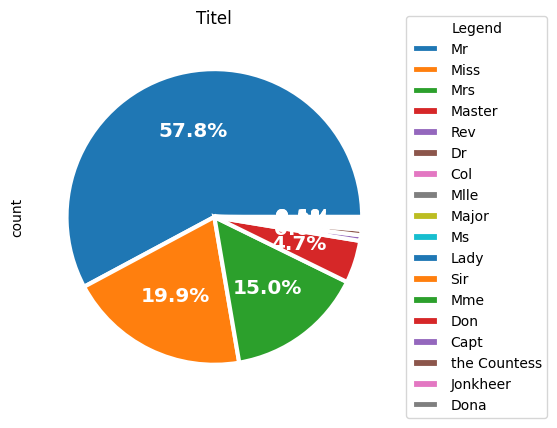

In [95]:
pie_chart = feature_engineering_df.Titel.value_counts().plot.pie(autopct='%.1f%%', 
                                                         wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'}, 
                                                         textprops=dict(size='x-large', color='white', fontweight='bold'))
pie_chart.set_title('Titel')

labels = feature_engineering_df.Titel.value_counts().index
plt.legend(labels, title="Legend", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.show()

In [96]:
# Miss
feature_engineering_df['Titel'] = feature_engineering_df['Titel'].replace(['Mlle', 'Mme','Ms'], 'Miss')
# Mrs
feature_engineering_df['Titel'] = feature_engineering_df['Titel'].replace(['Lady','the Countess','Dona'], 'Mrs')
# Mr
feature_engineering_df['Titel'] = feature_engineering_df['Titel'].replace(['Major', 'Col', 'Sir', 'Don', 'Jonkheer', 'Capt'], 'Mr')
# Extra (Titelgruppe bei der ich Männer und Frauen enddeckt habe)
feature_engineering_df['Titel'] = feature_engineering_df['Titel'].replace(['Dr', 'Rev'], 'Mixed')


# Titel als numerisches Feature
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Mixed": 5}
feature_engineering_df['Num_Titel'] = feature_engineering_df['Titel'].map(title_mapping)
feature_engineering_df.head(2)

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Dataset,Surname,Titel,First_Name,Sex,Num_Titel
0,1,0.0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,S,Train,Braund,Mr,Owen Harris,0,1
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,C,Train,Cumings,Mrs,John Bradley,1,3


<a id="15"></a>
### Feature: Ist Kind

Unter der Premise Frauen und Kinder zuerst Wäre interesant zusehen ob du ein Kind bist oder nicht

In [97]:
def calculate_points(row):
    if row['Age'] <= 8: # 8 Jahre haben sich beim ausprobieren als Sweetspot herausgestellt
        points = 1
    else:
        points = 0
    return points

# Neue Spalte 'Score' mit berechneten Punkten hinzufügen
feature_engineering_df['Is_Child'] = feature_engineering_df.apply(calculate_points, axis=1)

<a id="15"></a>
### Feature: Alter auffüllen

Im Datensatz fehlt ca. 250 Mal das Alter der Passagiere. Da dies ein wichtiges Feature ist muss es aufgefüllt werden. Idee ist diese über den Titel aufzufüllen, da ich meiner Meinung nach so die beste Abbdeckung hab (Darstellung der Daten). Ich habe die über verschiedene Pclassen mir auch die ähnlichsten Merkmale bzgl. des Überlebens darlegen. Mr haben in allen PClass am schlechtesten Überlebt. Mixed (Dr, Rev) gibt es nur in Pclass 1. etc. (Erste Idee eventuell neu machen... Eventuell Lin Regression??)

**TO-DO** 
- Lineare Regression testen.

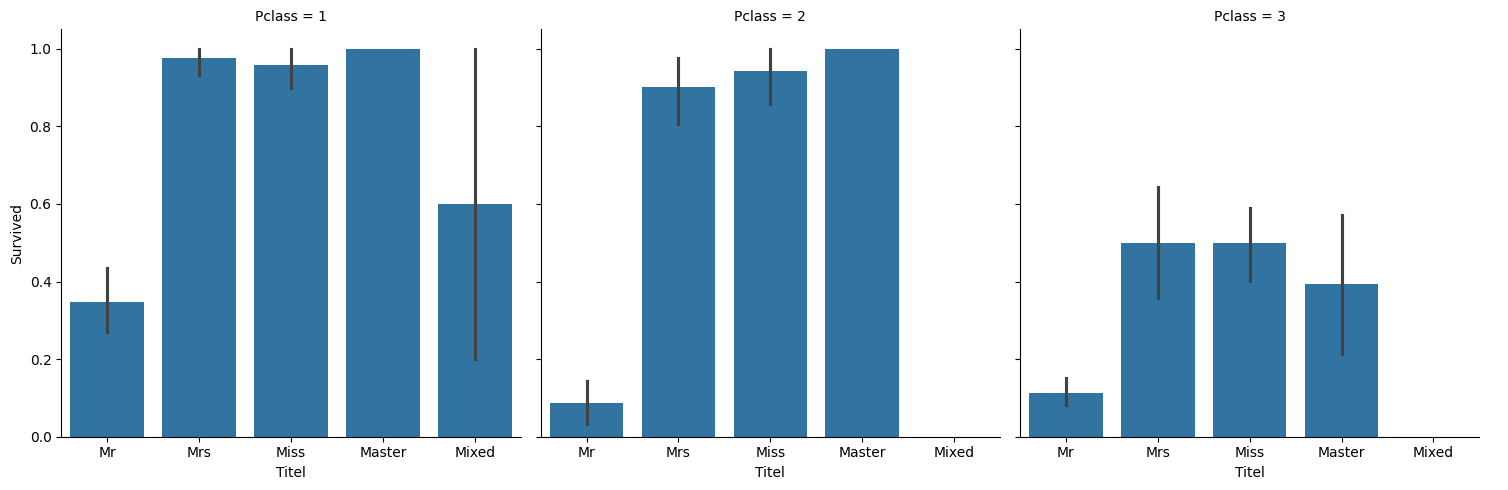

In [98]:
sns.catplot(x = 'Titel',  y = 'Survived', kind = 'bar', col = 'Pclass', data = feature_engineering_df)
plt.show()

In [99]:
def auffuellen_alter_nach_titel(df):
    # Berechne den Median des Alters für jeden Titel
    median_alter_pro_titel = df.groupby('Titel')['Age'].transform('median')
    # Fülle fehlende Alterswerte auf
    df['Age'] = df['Age'].fillna(median_alter_pro_titel)
    return df

feature_engineering_df = auffuellen_alter_nach_titel(feature_engineering_df)

<a id="15"></a>
### Feature: Altersgruppen

Zur vereinfachung des Alters-Features wird versucht die Passagiere in unterschiedliche Altersgruppen zu unterteil: Kind, Junge Erwachsene, Erwachsener, Alt (4 Gruppen)

In [100]:
feature_engineering_df['AgeGroup'] = pd.qcut(feature_engineering_df['Age'], 4) 
feature_engineering_df['AgeGroup'] = label_encoder.fit_transform(feature_engineering_df['AgeGroup'])
feature_engineering_df.head(2)

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Dataset,Surname,Titel,First_Name,Sex,Num_Titel,Is_Child,AgeGroup
0,1,0.0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,S,Train,Braund,Mr,Owen Harris,0,1,0,0
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,C,Train,Cumings,Mrs,John Bradley,1,3,0,3


<a id="8"></a>
### Feature: Familiengröße (Family_Size)

In [101]:
feature_engineering_df['Family_Size'] = (feature_engineering_df['SibSp'] + feature_engineering_df['Parch']+1)
feature_engineering_df.head(1)

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Dataset,Surname,Titel,First_Name,Sex,Num_Titel,Is_Child,AgeGroup,Family_Size
0,1,0.0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.25,NaN,S,Train,Braund,Mr,Owen Harris,0,1,0,0,2


Barplot mit mit der Verteilung der Familiengröße:

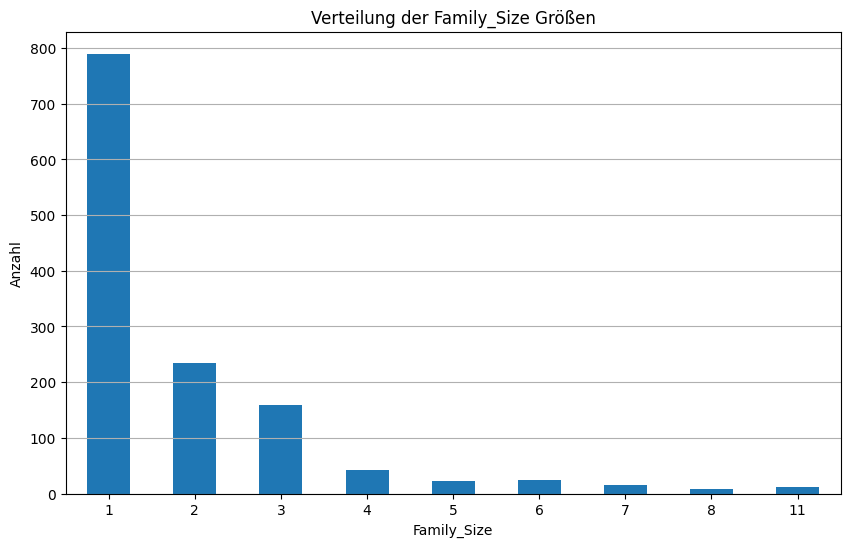

In [102]:
family_size_counts = feature_engineering_df['Family_Size'].value_counts().sort_index()
plt.figure(figsize=(10, 6))
family_size_counts.plot(kind='bar')
plt.title('Verteilung der Family_Size Größen')
plt.xlabel('Family_Size')
plt.ylabel('Anzahl')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()


Labeln der Familiengröße um das Feature zu vereinfachen:

In [103]:
def label_family_group(size):
    group = ''
    if (size <= 1):
        group = 'loner'
    elif (size <= 4):
        group = 'small'
    else:
        group = 'large'
    return group

feature_engineering_df['Family_Size_Label'] = feature_engineering_df['Family_Size'].apply(label_family_group)

# Numerisches Feature draus machen
feature_engineering_df['Family_Size_Label_encoded'] = label_encoder.fit_transform(feature_engineering_df['Family_Size_Label'])

feature_engineering_df.head()

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,...,Surname,Titel,First_Name,Sex,Num_Titel,Is_Child,AgeGroup,Family_Size,Family_Size_Label,Family_Size_Label_encoded
0,1,0.0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,...,Braund,Mr,Owen Harris,0,1,0,0,2,small,2
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,...,Cumings,Mrs,John Bradley,1,3,0,3,2,small,2
2,3,1.0,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,...,Heikkinen,Miss,Laina,1,2,0,1,1,loner,1
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,...,Futrelle,Mrs,Jacques Heath,1,3,0,2,2,small,2
4,5,0.0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,...,Allen,Mr,William Henry,0,1,0,2,1,loner,1


<a id="9"></a>
### Feature: Überlebensrate von Familien

Um eine Familie zu definieren blieb mir nichts anderes übrig als drei Features gemeinsam zu betrachten. Ticket, Fare und Surenam. Wie man untem am beispiel Andersson schön erkennen kann haben 11 Passagiere den Gleichen Nachnamen. Da diese Aber komlett unterschiedliche Family_Sizes haben fällt es mir schwer diese als Familie zu betrachten. Zudem fällt auf dass ein Großteil der Andersson unter der gleichen Ticketnummer (Ticket = 347082 ) und dem gleichen Ticketpreis (Fare = 31.2750) reisen. Während die anderen Anderssons unter anderem Ticket/Fare reisen. Ich werde im folgenden nur die Familien identifizieren können, die sich als solche auch ein gemeinsamens (ich denke Gruppenticket) gekauft haben

In [104]:
test = feature_engineering_df[feature_engineering_df["Surname"]=="Andersson"]
test

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,...,Surname,Titel,First_Name,Sex,Num_Titel,Is_Child,AgeGroup,Family_Size,Family_Size_Label,Family_Size_Label_encoded
13,14,0.0,3,"Andersson, Mr. Anders Johan",39.0,1,5,347082,31.2750,NaN,...,Andersson,Mr,Anders Johan,0,1,0,3,7,large,0
68,69,1.0,3,"Andersson, Miss. Erna Alexandra",17.0,4,2,3101281,7.9250,NaN,...,Andersson,Miss,Erna Alexandra,1,2,0,0,7,large,0
119,120,0.0,3,"Andersson, Miss. Ellis Anna Maria",2.0,4,2,347082,31.2750,NaN,...,Andersson,Miss,Ellis Anna Maria,1,2,1,0,7,large,0
146,147,1.0,3,"Andersson, Mr. August Edvard (""Wennerstrom"")",27.0,0,0,350043,7.7958,NaN,...,Andersson,Mr,August Edvard Wennerstrom,0,1,0,1,1,loner,1
541,542,0.0,3,"Andersson, Miss. Ingeborg Constanzia",9.0,4,2,347082,31.2750,NaN,...,Andersson,Miss,Ingeborg Constanzia,1,2,0,0,7,large,0
542,543,0.0,3,"Andersson, Miss. Sigrid Elisabeth",11.0,4,2,347082,31.2750,NaN,...,Andersson,Miss,Sigrid Elisabeth,1,2,0,0,7,large,0
610,611,0.0,3,"Andersson, Mrs. Anders Johan (Alfrida Konstant...",39.0,1,5,347082,31.2750,NaN,...,Andersson,Mrs,Anders Johan,1,3,0,3,7,large,0
813,814,0.0,3,"Andersson, Miss. Ebba Iris Alfrida",6.0,4,2,347082,31.2750,NaN,...,Andersson,Miss,Ebba Iris Alfrida,1,2,1,0,7,large,0
850,851,0.0,3,"Andersson, Master. Sigvard Harald Elias",4.0,4,2,347082,31.2750,NaN,...,Andersson,Master,Sigvard Harald Elias,0,4,1,0,7,large,0
1105,1106,NaN,3,"Andersson, Miss. Ida Augusta Margareta",38.0,4,2,347091,7.7750,NaN,...,Andersson,Miss,Ida Augusta Margareta,1,2,0,3,7,large,0


In [105]:
def berechne_familien_und_ticket_überlebensrate(df):
    # 50/50 Überlebensrate (egal ob mann frau oder kind)
    df['Family_Survival'] = 0.5
    
    for group_feature in [['Surname', 'Fare'], ['Ticket']]:
        for _, grp_df in df.groupby(group_feature):
            if len(grp_df) > 1: # wenn es eine gruppe ist
                if any(grp_df['Survived'] == 1):
                    df.loc[grp_df.index, 'Family_Survival'] = 1
                elif all(grp_df['Survived'] == 0):
                    df.loc[grp_df.index, 'Family_Survival'] = 0

    return df
feature_engineering_df = berechne_familien_und_ticket_überlebensrate(feature_engineering_df)
print("Anzahl der Passagiere mit Family_Survival:", len(feature_engineering_df.loc[feature_engineering_df['Family_Survival'] != 0.5]))

Anzahl der Passagiere mit Family_Survival: 462


In [106]:
# Funktion, um Punkte basierend auf dem Geschlecht und dem Alter zu berechnen
def calculate_points(row):
    if row['Age'] <= 8:
        points = 1
    else:
        points = 0
    return points

# Neue Spalte 'Score' mit berechneten Punkten hinzufügen
feature_engineering_df['Is_Child'] = feature_engineering_df.apply(calculate_points, axis=1)

# Funktion, um Punkte basierend auf dem Geschlecht und dem Alter zu berechnen
def calculate_points(row):
    if row['Embarked'] == "C":
        points = 1
    else:
        points = 0
    return points

# Neue Spalte 'Score' mit berechneten Punkten hinzufügen
feature_engineering_df['Is_from_Cherbourg'] = feature_engineering_df.apply(calculate_points, axis=1)


<a id="9"></a>
### Feature: Abfuhrhafen Cherbourg (C)

Wie man im folgenden Plot sehen kann haben Passagier die am Abfuhrhafen Cherbourg (C) verhältnismässig häufig überlebt. Das ist vorallem dann interessant wenn man sich betrachtet, das der Abfuhrhafen Cherbourg (C) nur der zweit häufigste abführhafen ist.

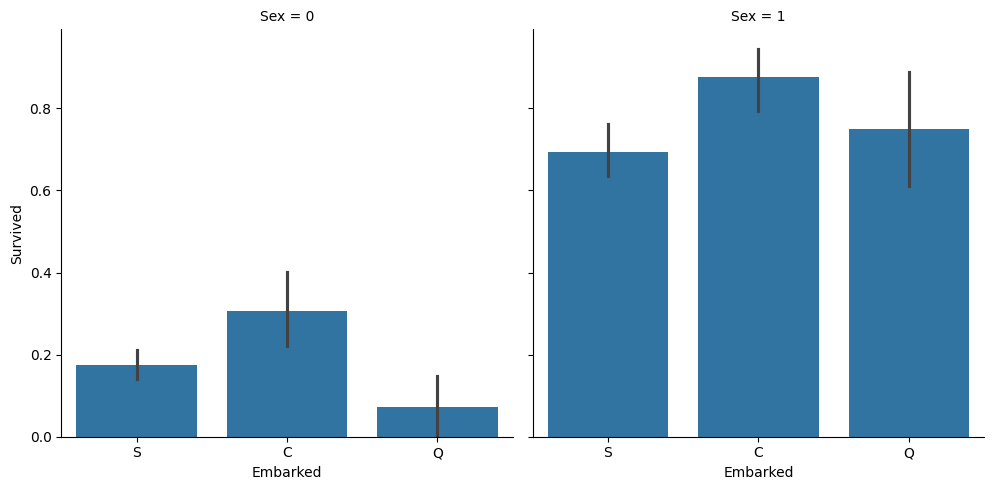

In [107]:
sns.catplot(x = 'Embarked', y = 'Survived', kind = 'bar', data = feature_engineering_df, col = 'Sex')
plt.show()

In [108]:
print("Anzahl der Passagiere pro Abfuhrhafen:")
feature_engineering_df['Embarked'].value_counts()

Anzahl der Passagiere pro Abfuhrhafen:


Embarked
S    916
C    270
Q    123
Name: count, dtype: int64

In [109]:
def calculate_points(row):
    if row['Embarked'] == "C":
        points = 1
    else:
        points = 0
    return points
feature_engineering_df['From_Cherbourg'] = feature_engineering_df.apply(calculate_points, axis=1)


<a id="9"></a>
### Feature: Fahrpreis pro Person

Wie bei der beim Feature Überlebensrate von Familien schon angerissen gibt es im Datensatz viele "Gruppentickets" die den tatsächlichen Fahrpreis pro Person nicht darstellt. Z.B. jedes Mitglied einer großen Familie mit einem teuren "Gruppenticket" hat dann im Datensatz einen teureren Fahrpreis (des Gruppentickets) als z.b ein Ticket aus der zweiten Klasse.

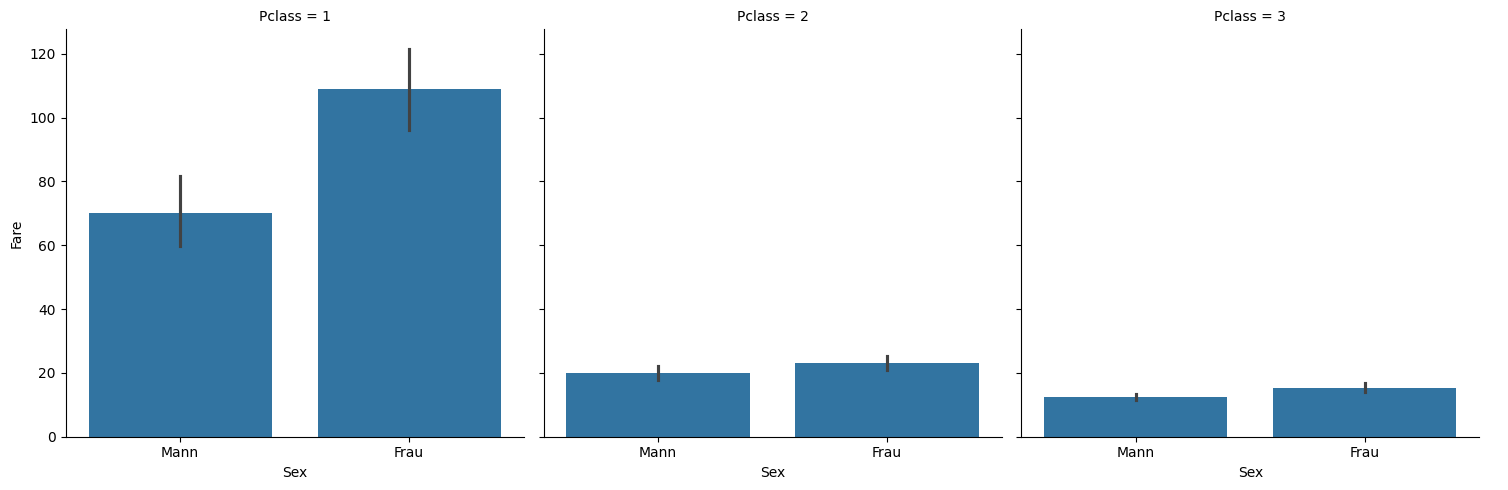

In [110]:
sns.catplot(x = 'Sex',  y = 'Fare', kind = 'bar', col = 'Pclass', data = feature_engineering_df)
plt.xticks(ticks=[0, 1], labels=['Mann', 'Frau'])
plt.show()

Behauptung kann wiederlegt werden aber es fällt aus dass über alle Pclass hinweg die Tickets der Frauen (1) Teurer sind. Ticketpreis geteilt durch Family_Size (Gruppengröße)

In [111]:
feature_engineering_df['calculated_fare'] = feature_engineering_df.Fare/feature_engineering_df.Family_Size

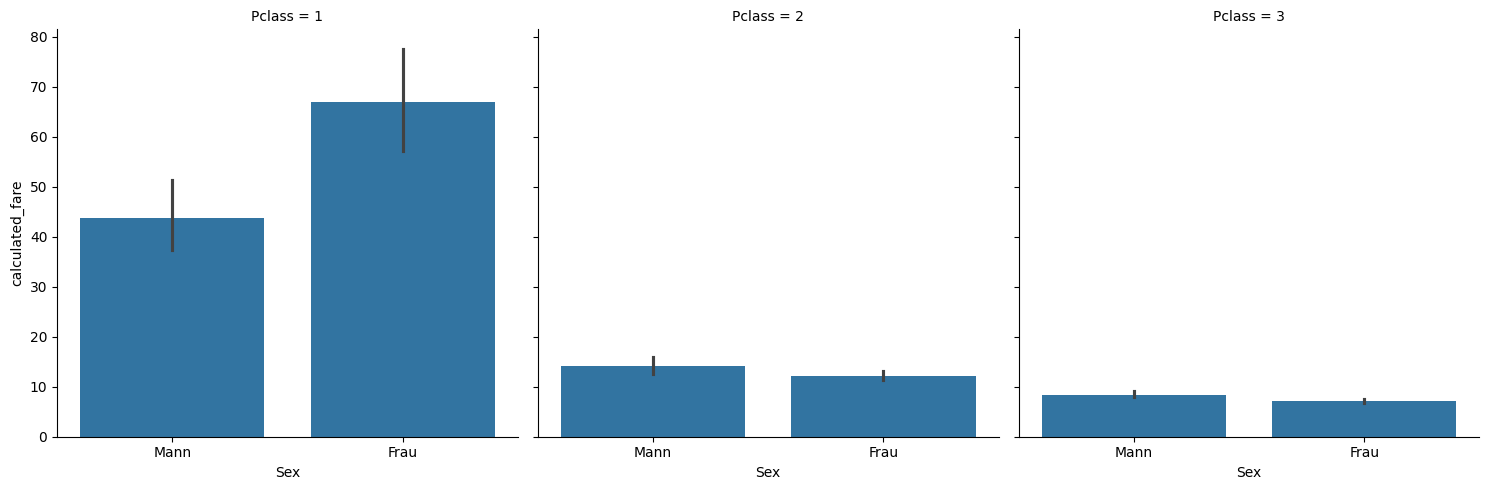

In [112]:
sns.catplot(x = 'Sex',  y = 'calculated_fare', kind = 'bar', col = 'Pclass', data = feature_engineering_df)
plt.xticks(ticks=[0, 1], labels=['Mann', 'Frau'])
plt.show()

Was sich durch den Split intersanterweise Ändert ist, dass sich die Ticketpreise in Pclass 2 und 3 ändern und die TIckets der Männer in diesen Klassen nun etwas teurer sind... Muss nun geschaut werden ob dass die Modelle verbessert:D

<a id="9"></a>
### Feature: Fahrpreisgruppen

Genauso wie bei dem Feature Altersgruppe möchte ich das Feature Fare vereinfachen in dem ich es in Gruppen aufteile. Die Gruppen diesmal sind: Sehr billig, billig, "mittel", teuer, sehr teurer (=5 Gruppen)

In [113]:
# feature_engineering_df['FareGroup'] = pd.qcut(feature_engineering_df['Fare'], 5) 
# feature_engineering_df['FareGroup'] = label_encoder.fit_transform(feature_engineering_df['Fare'])
# feature_engineering_df.head(2)

feature_engineering_df['FareGroup'] = pd.qcut(feature_engineering_df['calculated_fare'], 5) 
feature_engineering_df['FareGroup'] = label_encoder.fit_transform(feature_engineering_df['calculated_fare'])
feature_engineering_df.head(2)

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,...,Is_Child,AgeGroup,Family_Size,Family_Size_Label,Family_Size_Label_encoded,Family_Survival,Is_from_Cherbourg,From_Cherbourg,calculated_fare,FareGroup
0,1,0.0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,...,0,0,2,small,2,0.5,0,0,3.62500,19
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,...,0,3,2,small,2,1.0,1,1,35.64165,260


<a id="11"></a>
## Data Preprocessing 

In diesem Abschnitt wird der Dataframe feature_engineering_df geteilt, und so vorbereitet, dass verschiedene Modelle damit trainiert werden können. Im Folgenden ist die Liste der zur Verfügung stehenden Features:

In [114]:
print("Zur Verfügung stehende Features")
feature_engineering_df.info()

Zur Verfügung stehende Features
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   PassengerId                1309 non-null   int64  
 1   Survived                   891 non-null    float64
 2   Pclass                     1309 non-null   int64  
 3   Name                       1309 non-null   object 
 4   Age                        1309 non-null   float64
 5   SibSp                      1309 non-null   int64  
 6   Parch                      1309 non-null   int64  
 7   Ticket                     1309 non-null   object 
 8   Fare                       1309 non-null   float64
 9   Cabin                      295 non-null    object 
 10  Embarked                   1309 non-null   object 
 11  Dataset                    1309 non-null   object 
 12  Surname                    1309 non-null   object 
 13  Titel           

**XGBoost**

In [ ]:
features = ['PassengerId', 'Dataset', 'Survived', 'Sex', 'Pclass', 'Is_from_Cherbourg', 'Is_Child']

xgboost_features_df = feature_engineering_df[features]

# Aufteilen in Trainings- und Testdaten
train = feature_engineering_df[feature_engineering_df['Dataset']=="Train"].drop(['Dataset'], axis=1)
train["Survived"] = train["Survived"].astype(np.int64)
test = feature_engineering_df[feature_engineering_df['Dataset']=="Test"].drop(['Dataset', 'Survived'], axis=1)

**KNN**

In [ ]:
# # choose features and labels
# label = "Survived"
# features = ["Pclass", "Sex", "Family_Size", "Family_Survival", "FareBin_Code", "AgeGroup"]

# # split back feature_engineering_df into train and prediction sets
# train_df = feature_engineering_df[feature_engineering_df["Dataset"] == "Train"][features + [label]]
# test_df = feature_engineering_df[feature_engineering_df["Dataset"] == "Test"][features]

# # convert Survived variable to int for train dataset
# train_df["Survived"] = train_df["Survived"].astype(np.int64)

**IDEAL XGBoost:**

In [ ]:


# features = ['PassengerId', 'Dataset', 'Survived', 'Sex', 'Pclass', 'Is_from_Cherbourg', 'Is_Child']

# # Features zum Überlegen
# # Is Father from Young Child
# # Is Mother from Young Child


# '''
# Umständliches Regelwerk

# Wenn Man dann 0 -> wenn man aus p3 -> 0 wenn man aus p1 dann 1 -> wenn aus dem einen Hafen dann  1 ->  Wenn kind dann 1 (jünger 15) -> wenn aus dem anderen hafen dann 0 etc. -> Wenn vater etc.
# Wenn Frau dann 1 -> Wenn frau aus dem Crazy hafen dann 0 -> w
# '''

# '''
# Features die Score Verschlechtern: (Alle Features in Kombination mit Sex)
# - Is_Child
# - Fare
# - SurnameID (Mit Clustering)
# - Age
# - 'AverageSurvivalRate' (EXTREM unter 50 Prozent aber Accurancy auf Testdaten 96% -> Muss man besser machen)
# - 'Ticketnummer'
# - 'Surname_encoded'
# -'Speech_encoded'
# - 'Title'
# - 'calculated_fare'
# - 'SurnameID'
# - GroupSurvival (Katastrophal für den Score Sehr gut für Accurancy)
# - GroupedSurnameID
# - 'small_group_sibsp'


# '''

# '''
# Features die Score nicht beeinflussen: (Alle Features in Kombination mit Sex)
# - Pclass
# - Embarked_encoded
# - 'Married_Woman'
# - 'Is_from_Cherbourg'
# - 'Cheep_Ticket'
# - fare_group_encoded (In der Gruppe aber negativer Einfluss)
# - 'is_alone' (In der Gruppe aber negativer Einfluss)
# - 'Is_Old' (In der Gruppe aber negativer Einfluss)
# -  'Is_from_Queenstown' (in der Guppe beinflusst dieses Feature den Score nicht)

# '''

# '''
# Features die Score Verbessern: (Alle Features in Kombination mit Sex)
# - 'Parch' (Ohne SibSp verbesserung um 0.2 mit SibSp keine erhöhung)
# - 'SibSp' (Um 0.5)
# - 'Family_Size' (gleichgut wie SibSp keinen Unterschied)
# - 'Family_Size_Label_encoded'
# - 'Is_Mother' (alleine kaum aber in der Gruppe)
# - 'Is_Father' (alleine kaum aber in der Gruppe)


# '''

# '''
# Features Kombinationen die Score Verbessern: (Alle Features in Kombination mit Sex)
# -  79.9 = 'PassengerId', 'Dataset', 'Survived', 'Sex', 'Pclass', 'Is_from_Cherbourg', 'Is_Child' (Is Child Feature von 4 Jahre auf 8 Angepasst)
# -  79.1 = 'PassengerId', 'Dataset', 'Survived', 'Sex', 'Pclass', 'Is_from_Cherbourg', 'Is_Child'
# -  78.9 = 'Family_Size_Label_encoded' + 'Pclass' + 'Is_from_Cherbourg' (Hat minimal positiven einfluss 0.07) +'Is_Child' (keinen Unterschied) + 'Cheep_Ticket' (keinen Unterschied) + Is_Father' (um 0.7 auf 78.2)
# -  78.2 = 'Family_Size_Label_encoded' + 'Pclass' + 'Is_from_Cherbourg' (Hat minimal positiven einfluss 0.07) +'Is_Child' (keinen Unterschied) + 'Cheep_Ticket' (keinen Unterschied)+ Is_Mother' (um 0.7 auf 78.2)

# '''




# # features = ['PassengerId','Survived','Pclass', 'Age', 'SibSp', 'Parch', 'Ticketnummer', 'Fare', 'Dataset', 'Sex', 'SurnameID', 'Surname_encoded', 'Embarked_encoded', 'Speech_encoded', 'Family_Size', 'Score','Married_Woman']

# feature_engineering_df = feature_engineering_df[features]


# # # rom sklearn.preprocessing import StandardScaler
# # st_scale = StandardScaler()

# # # transforming "train_x"
# # feature_engineering_df = st_scale.fit_transform(feature_engineering_df)




# # Aufteilen in Trainings- und Testdaten
# train = feature_engineering_df[feature_engineering_df['Dataset']=="Train"].drop(['Dataset'], axis=1)
# test = feature_engineering_df[feature_engineering_df['Dataset']=="Test"].drop(['Dataset'], axis=1)

# # # Speichern als CSV
# # train.to_csv( data_path/'../csv/feature_data/train_engineered.csv', index=False)
# # test.to_csv(data_path/'../csv/feature_data/test_engineered.csv', index=False)

**IDEAL KNN:**

In [734]:
# # choose features and labels
# label = "Survived"
# features = ["Pclass", "Sex", "Family_Size", "Family_Survival", "FareBin_Code", "AgeGroup"]

# # split back feature_engineering_df into train and prediction sets
# train_df = feature_engineering_df[feature_engineering_df["Dataset"] == "Train"][features + [label]]
# test_df = feature_engineering_df[feature_engineering_df["Dataset"] == "Test"][features]

# # convert Survived variable to int for train dataset
# train_df["Survived"] = train_df["Survived"].astype(np.int64)

In [735]:
# train_df.head()

,Pclass,Sex,Family_Size,Family_Survival,FareBin_Code,AgeGroup,Survived
0,3,0,2,0.5,0,0,0
1,1,1,2,1.0,4,3,1
2,3,1,1,0.5,1,1,1
3,1,1,2,1.0,4,2,1
4,3,0,1,0.5,1,2,0


In [736]:
# test_df.head()

,Pclass,Sex,Family_Size,Family_Survival,FareBin_Code,AgeGroup
891,3,0,1,0.5,0,2
892,3,1,2,0.5,0,3
893,2,0,1,0.5,1,3
894,3,0,1,0.5,1,1
895,3,1,3,1.0,2,0


<a id="12"></a>
## Modells

<a id="x"></a>
### XGBoost

<a id="13"></a>
#### Modell-Setup 

In [ ]:
X_train = train.drop(['PassengerId', 'Survived'], axis=1)
y_train = train['Survived']

model = XGBClassifier(n_estimators=1000, random_state=7, use_label_encoder=False, eval_metric='logloss')

<a id="14"></a>
#### Modell-Training 

<a id="15"></a>
#### Modell-Prediction

<a id="x"></a>
### K-Nearest Neighbors 

<a id="13"></a>
#### Modell-Setup 

In [737]:
# setup dataframes
X = train_df[features]
y = train_df['Survived']
X_pred = test_df

# scale data for KNN classifier
std_scaler = StandardScaler()
X = std_scaler.fit_transform(X)
X_pred = std_scaler.transform(X_pred)

In [738]:
# setup parameters values for grid search
n_neighbors = [6,7,8,9,10,11,12,14,16,18,20,22]
weights = ['uniform', 'distance']
leaf_size = list(range(1,50,5))
hyperparams = {'weights': weights, 'leaf_size': leaf_size, 'n_neighbors': n_neighbors}


gd=GridSearchCV(estimator = KNeighborsClassifier(), param_grid = hyperparams, verbose=True, 
                cv=10, scoring = "roc_auc")

<a id="14"></a>
#### Modell-Training 

In [739]:
gd.fit(X, y)
print(gd.best_score_)
print(gd.best_estimator_)

Fitting 10 folds for each of 240 candidates, totalling 2400 fits


0.9084034179328299
KNeighborsClassifier(leaf_size=26, n_neighbors=12)


<a id="15"></a>
#### Modell-Prediction

In [740]:
# make predictions
gd.best_estimator_.fit(X, y)
y_pred = gd.best_estimator_.predict(X_pred)

In [741]:
# output predictions dataframe
temp = pd.DataFrame(pd.read_csv(data_path/'../csv/original_data/test.csv')['PassengerId'])
temp['Survived'] = y_pred
temp.to_csv("submission_test.csv", index = False)